In [1]:
import matplotlib.pylab as plt
import numpy as np
from osgeo import gdal
import osr

# from scipy import misc
# raster = misc.imread('HillslopeOnlyVeg.tif')

In [2]:
%matplotlib inline

In [3]:
image = np.flipud(plt.imread('../FourierWindowMethodMATLAB/ExamplePattern2.tiff'))

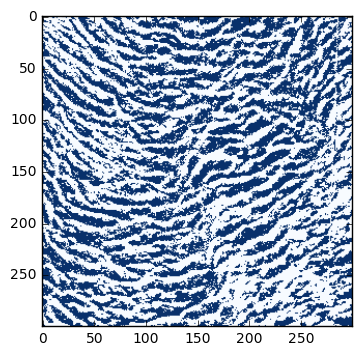

In [9]:
image[image != 0] = 1
plt.imshow(image, cmap = 'Blues')

In [11]:

Nx = image.shape[1]
Ny = image.shape[0]

In [12]:
f = open("ti.gslib", "w")
f.write('{0} {0} 1 1 1 1 0 0 0\n'.format(Nx, Ny))
f.write('1\n')
f.write('veg\n')
for i in range(Ny):
    for j in range(Nx):
        f.write(' {}\n'.format(str(image[i,j])))

NameError: name 'dem' is not defined

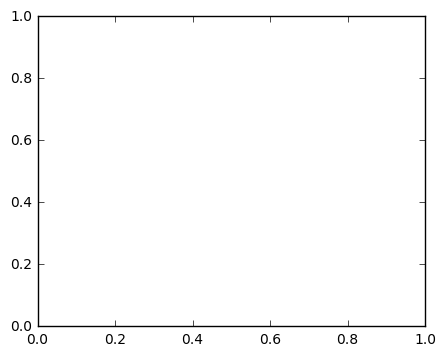

In [13]:
# 1. DEM of the hillslope (HillslopeDEM.tif).

plt.figure(figsize = (11, 4))
plt.subplot(121)
plt.imshow(dem[ yi/5:yi/5+ dy/5,xi/5:xi/5 + dx/5], 
           cmap='gist_earth', interpolation='none')
plt.colorbar()
plt.title('Elevation')

# 2.  A slope inclination layer (Dem_Slope.tif)

plt.subplot(122)
plt.imshow(veg[yi:yi+ dy,xi:xi+ dx],
           cmap='Blues',interpolation='none')
plt.colorbar()
plt.title('Slope')

# plt.imshow(slope, cmap='gist_earth', extent=[x0, x1, y1, y0])

In [25]:
xspaces = []
count = 0
for i in range(0, Ny):
    for j in range(0, Nx):
        if testveg[i, j] == 0:
            count += 1
        elif testveg[i,j] ==1 and testveg[i, j-1] ==0:
            xspaces.append(count)
            count = 0
    

In [26]:
yspaces = []
count = 0
for j in range(0, Nx):
    for i in range(0, Ny):
        if testveg[i, j] ==0:
            count += 1
        elif testveg[i, j] == 1 and testveg[i-1, j] ==0:
            yspaces.append(count)
            count = 0


In [27]:
xspaces = np.array(xspaces)
xspaces = xspaces[xspaces > 0]

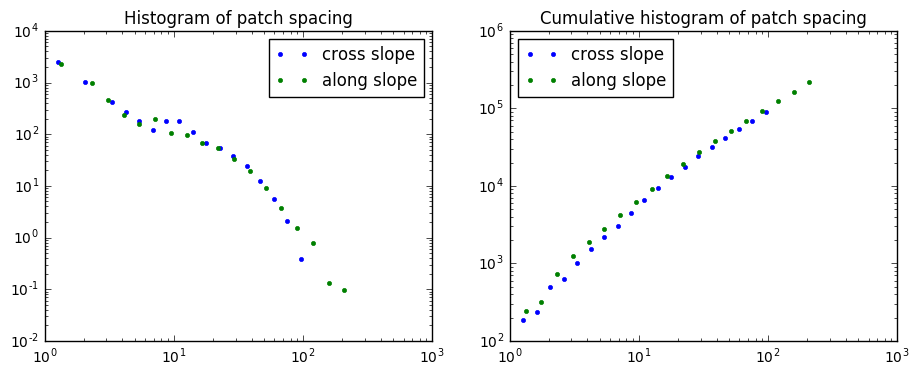

In [28]:
plt.figure(figsize = (11, 4))

plt.subplot(121)
xtest = plt.histogram(xspaces, bins=np.logspace(0.0, np.log10(max(xspaces)), 20))
counts = xtest[0]; bins = xtest[1]
norm  = bins[1:] - bins[:-1]
plt.loglog(bins[1:], counts/norm, '.', label = 'cross slope')

ytest = plt.histogram(yspaces, bins=np.logspace(0.0, np.log10(max(yspaces)), 20))
counts = ytest[0]; bins = ytest[1]
norm  = bins[1:] - bins[:-1]
plt.loglog(bins[1:], counts/norm, '.', label = 'along slope')
plt.legend(loc = 'best')
plt.title('Histogram of patch spacing')


plt.subplot(122)
xtest = plt.histogram(xspaces, bins=np.logspace(0.0, np.log10(max(xspaces)), 20))
counts = xtest[0]; bins = xtest[1]
norm  = bins[1:] - bins[:-1]
plt.loglog(bins[1:], np.cumsum(counts)*norm, '.', label = 'cross slope')

ytest = plt.histogram(yspaces, bins=np.logspace(0.0, np.log10(max(yspaces)), 20))
counts = ytest[0]; bins = ytest[1]
norm  = bins[1:] - bins[:-1]
plt.loglog(bins[1:], np.cumsum(counts)*norm, '.', label = 'along slope')
plt.legend(loc = 'best')
plt.title('Cumulative histogram of patch spacing')
# # plt.imshow(slope, cmap='gist_earth', extent=[x0, x1, y1, y0])

In [29]:
import powerlaw 
results = powerlaw.Fit(xspaces) 
print results.power_law.alpha 
print results.power_law.xmin 


4.439710756
32.0


Calculating best minimal value for power law fit
//anaconda/lib/python2.7/site-packages/powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


### Patch size

In [31]:
import numpy
from scipy import ndimage

s = ndimage.generate_binary_structure(2,2) # iterate structure
s[0, 0] = 0
s[2, 0] = 0
s[2, 2] = 0
s[0, 2] = 0

labeled_array, numpatches = ndimage.label(testveg,s) # labeling

sizes = ndimage.sum(testveg,labeled_array,range(1,numpatches+1)) 
# # To get the indices of all the min/max patches. Is this the correct label id?
# map = numpy.where(sizes==sizes.max())[0] + 1 
# mip = numpy.where(sizes==sizes.min())[0] + 1

# # inside the largest, respecitively the smallest labeled patches with values
# max_index = np.zeros(numpatches + 1, np.uint8)
# max_index[map] = 1
# max_feature = max_index[labeled_array]

# min_index = np.zeros(numpatches + 1, np.uint8)
# min_index[mip] = 1
# min_feature = min_index[labeled_array]

In [33]:
print 'mean patch density = {0:.3f}'.format(np.sum(sizes)/Nx/Ny)
print 'mean patch size = {0:.1f}'.format(float(np.mean(sizes)))


mean patch density = 0.204
mean patch size = 8.6


alpha = 1.93, sigma = 0.04


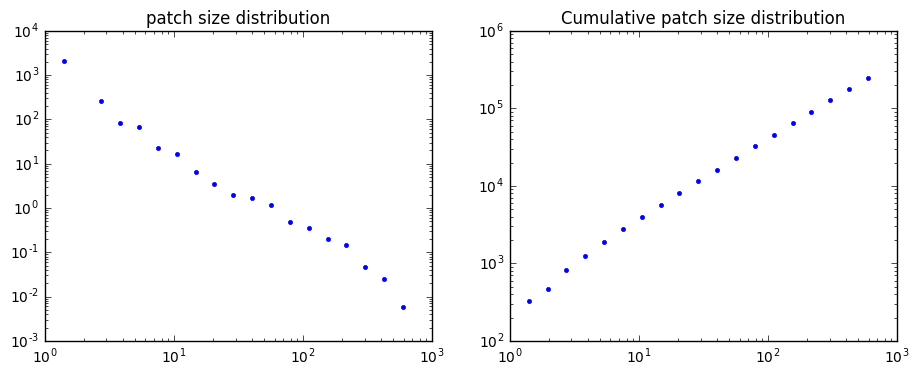

In [34]:
n = sizes[sizes >= 2].shape[0]
alpha = 1+ n/np.sum(np.log(sizes[sizes >= 2.]/2.))
sigma = (alpha - 1)/np.sqrt(n)
print 'alpha = {0:.2f}, sigma = {1:.2f}'.format(alpha, sigma)


plt.figure(figsize = (11, 4))
plt.subplot(121)
test = plt.histogram(sizes, bins=np.logspace(0.0, np.log10(max(sizes)), 20))
counts = test[0]
bins = test[1]
norm  = bins[1:] - bins[:-1]
plt.loglog(bins[1:], counts/norm, '.')
plt.title('patch size distribution')

plt.subplot(122)
test = plt.histogram(sizes, bins=np.logspace(0.0, np.log10(max(sizes)), 20))
counts = test[0]
bins = test[1]
norm  = bins[1:] - bins[:-1]
plt.loglog(bins[1:], np.cumsum(counts)*norm, '.')
plt.title('Cumulative patch size distribution')


In [35]:
import powerlaw 
results = powerlaw.Fit(sizes) 
print results.power_law.alpha 
print results.power_law.xmin 


1.93051571106
2.0


Calculating best minimal value for power law fit


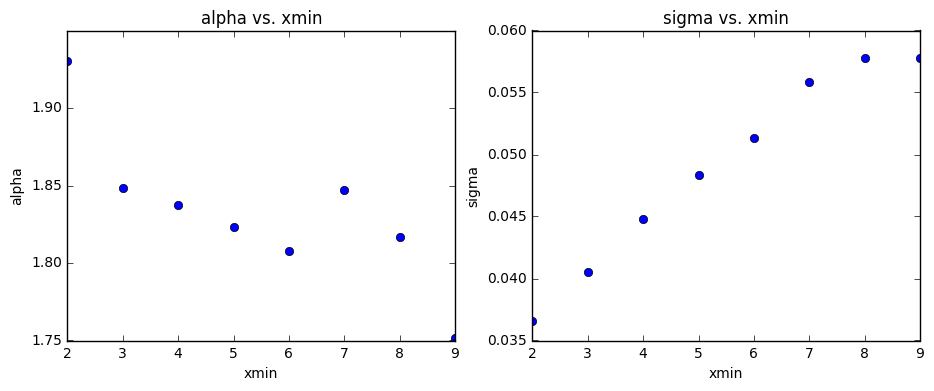

In [36]:
ns = []
alphas = []
sigmas = []
bins = range(2, 10)
for i in bins:
    ns.append(  sizes[sizes >= i].shape)
    alphas.append(1+ sizes[sizes >= i].shape/np.sum(np.log(sizes[sizes >= i]/i)))
    sigmas.append((alphas[i-bins[0]] - 1)/np.sqrt(ns[i-bins[0]]))
    
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(bins, alphas, 'o')
plt.title('alpha vs. xmin'); plt.xlabel('xmin');  plt.ylabel('alpha')
plt.subplot(122)
plt.plot(bins, sigmas, 'o')
plt.title('sigma vs. xmin'); plt.xlabel('xmin');  plt.ylabel('sigma')


-  Add edges to patch size file

In [43]:
def get_edges(fld):
    import scipy.signal

    s = np.ones((3, 3)) # iterate structure
    s[0, 0] = 0
    s[2, 0] = 0
    s[2, 2] = 0
    s[0, 2] = 0
    
    counts = scipy.signal.convolve2d(fld, s, mode='same')
    counts[fld == 0] = 0
    counts[counts == 5] = 0
    counts[counts>0] = 1
    return counts

In [44]:
edges = get_edges(testveg)

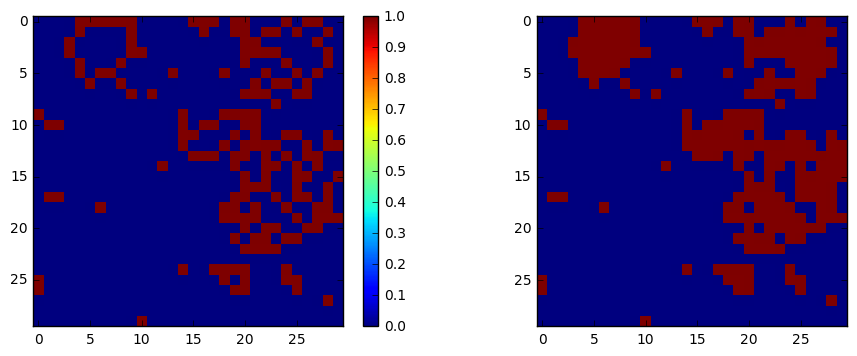

In [45]:
plt.figure(figsize=  (11, 4))
plt.subplot(121)
plt.imshow(edges[:30, :30], interpolation='none')
plt.colorbar()
plt.subplot(122)
plt.imshow(testveg[:30, :30], interpolation='none')


In [46]:

def get_edge_fraction(fld):
    edges = get_edges(fld)
    
    s = np.ones((3, 3)) # iterate structure
    s[0, 0] = 0
    s[2, 0] = 0
    s[2, 2] = 0
    s[0, 2] = 0
    
    labeled_array, numpatches = ndimage.label(fld,s) # labeling
    sizes = ndimage.sum(fld,labeled_array,range(1,numpatches+1)) 
    
    labeled_array, numpatches = ndimage.label(edges,s) # labeling
    edge_sizes = ndimage.sum(fld,labeled_array,range(1,numpatches+1)) 
    return sum(edge_sizes)/sum(sizes)

In [47]:
edge_fraction = get_edge_fraction(testveg)

In [48]:
print 'edge density = {0:.3f}'.format(np.sum(edges)/Nx/Ny)
print 'edge fraction = {0:.3f}'.format(edge_fraction)

edge density = 0.137
edge fraction = 0.671
